In [38]:
import distutils.util
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import math

# assuming running from raycasting-simulation/Automator
sys.path.append("../PycastWorld")

from math import acos, asin, atan, cos, sin, tan, pi
from math import floor
from math import radians
from pycaster import PycastWorld, Turn, Walk
from numpy.random import default_rng

rng = default_rng()

# NOISE CONTROL
# the standard deviation of the Gaussian that random angles are drawn from
rand_angle_scale = pi / 36  # 5 degree s.d.

# the minimum of the uniform distribution that random distances (to move) are drawn from
rand_step_scale = 0.4

enws = {"Dir.EAST": 0, "Dir.NORTH": 90, "Dir.WEST": 180, "Dir.SOUTH": 270}


def in_targ_cell(base_dir, c_targ_x, c_targ_y, x, y):
    if base_dir == 0 or base_dir == 180:
        if abs(c_targ_x - x) < 0.4:
            return True
    else:
        if abs(c_targ_y - y) < 0.4:
            return True
    return False


class Driver:
    def __init__(
        self, c_targ_x, c_targ_y, base_dir, targ_dir, world, img_dir=None, show_freq=0, abs_base_dir=0
        
    ):
        self.c_targ_x = c_targ_x
        self.c_targ_y = c_targ_y
        self.base_dir = base_dir
        self.targ_dir = targ_dir

        self.prev_targ_angle = 0

        self.world = world
        self.curr_x = self.world.x()
        self.curr_y = self.world.y()

        self.direction = 0
        self.update_direction()

        self.dist = math.inf
        self.update_dist()

        self.angle = 0
        self.step = math.inf

        self.all_angles = np.array([])
        self.all_base_angles = np.array([])
        
        self.abs_base_dir = abs_base_dir

        self.img_dir = img_dir
        if self.img_dir != None:
            stack_conds = []
            stack_conds.append(os.path.isdir(os.path.join(img_dir, "left")))
            stack_conds.append(os.path.isdir(os.path.join(img_dir, "right")))
            stack_conds.append(os.path.isdir(os.path.join(img_dir, "straight")))

            # if subdirectories exist, then stacking method not used
            if all(stack_conds):
                self.img_num_l = len(os.listdir(os.path.join(img_dir, "left")))
                self.img_num_r = len(os.listdir(os.path.join(img_dir, "right")))
                self.img_num_s = len(os.listdir(os.path.join(img_dir, "straight")))
                self.stack_dir = False
            else:
                self.img_num = len(os.listdir(img_dir))
                self.stack_dir = True

        self.show_freq = show_freq

    def update_dist(self):
        self.dist = math.sqrt(
            (self.c_targ_x - self.world.x()) ** 2
            + (self.c_targ_y - self.world.y()) ** 2
        )

    def update_direction(self):
        if not -1 <= self.world.get_dir_x() <= 1:
            dir_x = round(self.world.get_dir_x())
        else:
            dir_x = self.world.get_dir_x()

        if not -1 <= self.world.get_dir_y() <= 1:
            dir_y = round(self.world.get_dir_y())
        else:
            dir_y = self.world.get_dir_y()

        if dir_x > 0 and dir_y >= 0:
            dir = acos(dir_x)
        elif dir_x <= 0 and dir_y >= 0:
            dir = acos(dir_x)
        elif dir_x < 0 and dir_y < 0:
            dir = pi - asin(dir_y)
        elif dir_x >= 0 and dir_y < 0:
            dir = asin(dir_y)

        self.direction = dir % (2 * pi)

    # adjust for smoother path
    def modified_targ(self, delta):
        if self.base_dir == 0 or self.base_dir == 180:
            if self.targ_dir == 90:
                return self.c_targ_x, self.c_targ_y + delta
            elif self.targ_dir == 270:
                return self.c_targ_x, self.c_targ_y - delta
        elif self.base_dir == 90 or self.base_dir == 270:
            if self.targ_dir == 0:
                return self.c_targ_x + delta, self.c_targ_y
            elif self.targ_dir == 180:
                return self.c_targ_x - delta, self.c_targ_y
        return self.c_targ_x, self.c_targ_y

    def get_angle(self):
        mod_x, mod_y = self.modified_targ(0.15)
        if self.curr_x <= mod_x and self.curr_y <= mod_y:
            if mod_x == self.curr_x:
                theta = pi / 2
            else:
                theta = (atan((mod_y - self.curr_y) / (mod_x - self.curr_x))) % (2 * pi)

        # case where target pos is up and to the left
        elif self.curr_x > mod_x and self.curr_y <= mod_y:
            if mod_y == self.curr_y:
                theta = pi
            else:
                theta = (atan((self.curr_x - mod_x) / (mod_y - self.curr_y))) % (2 * pi) + pi / 2

        # case where target pos is down and to the left
        elif self.curr_x > mod_x and self.curr_y > mod_y:
            if mod_x == self.curr_x:
                theta = 3 * pi / 2
            else:
                theta = (atan((self.curr_y - mod_y) / (self.curr_x - mod_x))) % (2 * pi) + pi

        # case where target pos is down and to the right
        else:
            if self.curr_y == mod_y:
                theta = 0
            else:
                theta = (atan((mod_x - self.curr_x) / (self.curr_y - mod_y))) % (2 * pi) + 3 * pi / 2
        return theta

    def set_rand_angle(self):
        theta = self.get_angle()
        self.angle = rng.normal(loc=theta, scale=rand_angle_scale) % (2 * pi)

    def set_rand_step(self):
        self.step = rng.uniform(rand_step_scale, self.dist_to_wall())

    def abs_angle_diff(self, angle):
        abs_diff = abs(self.direction - angle)
        return abs_diff % (2 * pi)

    def turn_right(self, angle):
        if self.direction > angle:
            if self.direction - angle > pi:
                return False
            else:
                return True
        else:
            if angle - self.direction > pi:
                return True
            else:
                return False

    def turn_to_angle(self):
        self.world.walk(Walk.Stop)
        i = 0
        prev_turn = None
        turn_angle = 0.0
        angle_deg = self.angle * (180/pi)
        num_turns = 1

#         print(f"abs_ base dir: {self.abs_base_dir}")
#         curr_dir = self.world.directions() * (180/pi)
                
        while self.abs_angle_diff(self.angle) > 0.1:
            if self.turn_right(self.angle):
                if prev_turn == "left":
                    print("no left to right allowed")
                    break
                
                agent_dir = -abs(90 + turn_angle)
       
                angle_label = agent_dir
                print(f"RIGHT DIR: {turn_angle}")
                print(f"RIGHT LABEL: {angle_label}")
                self.all_angles = np.append(self.all_angles, angle_label)
                if self.img_dir != None:
                    if self.stack_dir:
                        self.world.save_png(
                            os.path.join(
                                self.img_dir, f"{self.img_num:05}_{angle_label}.png",
                            )
                        )
                        self.img_num += 1
                    else:
                        self.world.save_png(
                            os.path.join(
                                self.img_dir,
                                "right",
                                f"{self.img_num_r:05}_{angle_label}.png",
                            )
                        )
                        self.img_num_r += 1

                self.world.turn(Turn.Right)
                turn_angle -= 2.5  # self.world.getTurnSpeed() * (180 / pi)
                self.world.update()

                prev_turn = "right"

            else:
                if prev_turn == "right":
                    print("no right to left allowed")
                    break
                    
                agent_dir = abs(90 - turn_angle)

                angle_label = agent_dir
                print(f"LEFT DIR: {turn_angle}")
                print(f"LEFT LABEL: {angle_label}")
                self.all_angles = np.append(self.all_angles, angle_label)                
                if self.img_dir != None:
                    if self.stack_dir:
                        self.world.save_png(
                            os.path.join(
                                self.img_dir, f"{self.img_num:05}_{angle_label}.png",
                            )
                        )
                        self.img_num += 1
                    else:
                        self.world.save_png(
                            os.path.join(
                                self.img_dir,
                                "left",
                                f"{self.img_num_l:05}_{angle_label}.png",
                            )
                        )
                        self.img_num_l += 1

                self.world.turn(Turn.Left)
                turn_angle += 2.5  # self.world.getTurnSpeed() * (180 / pi)
                self.world.update()

                prev_turn = "left"

            if self.show_freq != 0:
                if i % self.show_freq == 0:
                    image_data = np.array(self.world)
                    plt.imshow(image_data)
                    plt.show()
                i += 1

            self.update_direction()

        print("\n")
        self.world.turn(Turn.Stop)

    @staticmethod
    def solve_triangle(theta, a):
        b = a * tan(theta)
        c = a / cos(theta)
        return b, c

    def dist_to_wall(self):
        if self.targ_dir == 0:
            if (3 * pi / 2) <= self.direction <= (2 * pi):
                a = self.world.y() - (self.c_targ_y - 0.5)
                theta = self.direction - (3 * pi / 2)
            else:
                a = (self.c_targ_y + 0.5) - self.world.y()
                theta = self.direction
        elif self.targ_dir == 90:
            if 0 <= self.direction <= (pi / 2):
                a = (self.c_targ_x + 0.5) - self.world.x()
                theta = self.direction
            else:
                a = self.world.x() - (self.c_targ_x - 0.5)
                theta = pi - self.direction
        elif self.targ_dir == 180:
            if (pi / 2) <= self.direction <= pi:
                a = (self.c_targ_y + 0.5) - self.world.y()
                theta = self.direction - (pi / 2)
            else:
                a = self.world.y() - (self.c_targ_y - 0.5)
                theta = (3 * pi / 2) - self.direction
        elif self.targ_dir == 270:
            if pi <= self.direction <= 3 * pi / 2:
                a = self.world.x() - (self.c_targ_x - 0.5)
                theta = self.direction - pi
            else:
                a = (self.c_targ_x + 0.5) - self.world.x()
                theta = (2 * pi) - self.direction

        b, c = self.solve_triangle(theta, a)

        if b < self.dist:
            return c
        else:
            return b

    def move_to_step(self):
        self.world.turn(Turn.Stop)
        i = 0
        while (
            not in_targ_cell(
                self.base_dir, self.c_targ_x, self.c_targ_y, self.curr_x, self.curr_y
            )
            and self.step > 0.1
        ):
            angle_label = 0
            self.all_angles = np.append(self.all_angles, angle_label)
            if self.img_dir != None:
                if self.stack_dir:
                    self.world.save_png(
                        os.path.join(
                            self.img_dir, f"{self.img_num:05}_{angle_label}.png",
                        )
                    )
                    self.img_num += 1
                else:
                    self.world.save_png(
                        os.path.join(
                            self.img_dir,
                            "straight",
                            f"{self.img_num_s:05}_{angle_label}.png",
                        )
                    )
                    self.img_num_s += 1

            self.world.walk(Walk.Forward)
            self.world.update()

            self.curr_x = self.world.x()
            self.curr_y = self.world.y()

            if self.show_freq != 0:
                if i % self.show_freq == 0:
                    image_data = np.array(self.world)
                    plt.imshow(image_data)
                    plt.show()
                i += 1

            self.step -= self.world.walk_speed()
            self.update_dist()

        self.world.walk(Walk.Stop)


class Navigator:
    def __init__(self, maze, img_dir=None):
        self.world = PycastWorld(320, 240, maze)
        self.img_dir = img_dir
        self.abs_base_dir = 0
        self.abd_targ_dir = 0

        # getting directions
        with open(maze, "r") as in_file:
            png_count = int(in_file.readline())
            for _ in range(png_count):
                in_file.readline()

            _, dim_y = in_file.readline().split()
            for _ in range(int(dim_y)):
                in_file.readline()

            self.directions = in_file.readlines()

        self.num_directions = len(self.directions)

        self.angles = np.array([])
        self.base_angles = np.array([])
        self.dirs = []

    def navigate(self, index, show_dir=False, show_freq=0):
        _, _, s_base_dir = self.directions[index].split()
        targ_x, targ_y, s_targ_dir = self.directions[index + 1].split()
        targ_x, targ_y = int(targ_x), int(targ_y)
        

        # convert from string
        base_dir = enws[s_base_dir]
        targ_dir = enws[s_targ_dir]        
        
        if base_dir != targ_dir :
            self.abs_base_dir = base_dir
            self.abs_targ_dir = targ_dir
        if self.abs_base_dir == 0:
            self.abs_base_dir = 360
            
        _, _, s_prev_dir = None, None, None
        prev_dir = None
        if index >= 1:            
            s_prev_dir = s_targ_dir
            prev_dir = enws[s_prev_dir]
            if base_dir != prev_dir:
                self.abs_base_dir = prev_dir
        # we know prev direction; calculate the angle direction we need and 
        # keep that angle direction until the current direction changes again. 
        # e.g. West -> North means turn right until North -> East so on and so forth
        if show_dir:
            print(f"Directions: {targ_x}, {targ_y}, {s_targ_dir}, basedir: {s_base_dir}, \
            abs base dir: {self.abs_base_dir}\
            prev dir: {s_prev_dir}")

        # center of target cell
        c_targ_x = targ_x + 0.5
        c_targ_y = targ_y + 0.5

        driver = Driver(
            c_targ_x, c_targ_y, base_dir, targ_dir, self.world, self.img_dir, show_freq, self.abs_base_dir
        )

        while not in_targ_cell(
            base_dir, c_targ_x, c_targ_y, driver.curr_x, driver.curr_y
        ):
            driver.set_rand_angle()
            driver.turn_to_angle()
            driver.set_rand_step()
            driver.move_to_step()
        
#         print("made it to targ cell..moving to next")
        self.angles = np.append(self.angles, driver.all_angles)
        return prev_dir

    def plot_angles(self):
        plt.plot(self.angles)
        plt.show()

    def plot_directions(self):
        plt.plot(self.dirs)
        plt.show()

    def plot_label_dir(self):
        plt.plot(self.directions)
        plt.show()

In [39]:
mazes = ["../Mazes/15_mazes_test_06-07-2021_22-37/maze_5.txt"]
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_2.txt", 
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_3.txt",
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_4.txt",
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_5.txt",
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_6.txt",
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_7.txt", 
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_8.txt",
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_9.txt",
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_10.txt",
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_11.txt",
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_12.txt", 
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_13.txt",
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_14.txt",
#          "../Mazes/15_mazes_test_06-07-2021_22-37/maze_15.txt"]

for m in mazes:
    maze = m
    print(maze)
    show_freq = 0  # frequency to show frames
    img_dir = "/raid/Images/proxy_reg" # directory to save images to
    show_dir = True

    navigator = Navigator(maze, img_dir)

    j = 0
    while j < navigator.num_directions - 1:
        navigator.navigate(j, show_dir=show_dir, show_freq=show_freq)
        j += 1

../Mazes/15_mazes_test_06-07-2021_22-37/maze_5.txt
Directions: 3, 1, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: None
RIGHT DIR: 0.0
RIGHT LABEL: -90.0


LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0




Directions: 5, 1, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST
RIGHT DIR: 0.0
RIGHT LABEL: -90.0
RIGHT DIR: -2.5
RIGHT LABEL: -87.5
RIGHT DIR: -5.0
RIGHT LABEL: -85.0


LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0


RIGHT DIR: 0.0
RIGHT LABEL: -90.0
RIGHT DIR: -2.5
RIGHT LABEL: -87.5
RIGHT DIR: -5.0
RIGHT LABEL: -85.0


Directions: 7, 1, Dir.NORTH, basedir: Dir.EAST,             abs base dir: 90            prev dir: Dir.NORTH
LEFT DIR: 0.0
LEFT LABEL: 90.0


LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0


Directions: 7, 3, Dir.NORTH, basedir: Dir.NORTH,             ab







RIGHT DIR: 0.0
RIGHT LABEL: -90.0
RIGHT DIR: -2.5
RIGHT LABEL: -87.5


LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5


LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5




RIGHT DIR: 0.0
RIGHT LABEL: -90.0
RIGHT DIR: -2.5
RIGHT LABEL: -87.5
RIGHT DIR: -5.0
RIGHT LABEL: -85.0
RIGHT DIR: -7.5
RIGHT LABEL: -82.5






LEFT DIR: 0.0
LEFT LABEL: 90.0


LEFT DIR: 0.0
LEFT LABEL: 90.0


LEFT DIR: 0.0
LEFT LABEL: 90.0


RIGHT DIR: 0.0
RIGHT LABEL: -90.0






LEFT DIR: 0.0
LEFT LABEL: 90.0


RIGHT DIR: 0.0
RIGHT LABEL: -90.0
RIGHT DIR: -2.5
RIGHT LABEL: -87.5


LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0




RIGHT DIR: 0.0
RIGHT LABEL: -90.0
RIGHT DIR: -2.5
RIGHT LABEL: -87.5
































LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0


RIGHT DIR: 0.0
RIGHT LABEL: -90.0




RIGHT DIR: 0.0
RIGHT LABEL: -90.0












LEFT DIR: 0.0
LEFT LABEL: 90



RIGHT DIR: 0.0
RIGHT LABEL: -90.0


LEFT DIR: 0.0
LEFT LABEL: 90.0




LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0


Directions: 9, 11, Dir.EAST, basedir: Dir.NORTH,             abs base dir: 0            prev dir: Dir.EAST
LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0
LEFT DIR: 7.5
LEFT LABEL: 82.5
LEFT DIR: 10.0
LEFT LABEL: 80.0
LEFT DIR: 12.5
LEFT LABEL: 77.5
LEFT DIR: 15.0
LEFT LABEL: 75.0
LEFT DIR: 17.5
LEFT LABEL: 72.5
LEFT DIR: 20.0
LEFT LABEL: 70.0
LEFT DIR: 22.5
LEFT LABEL: 67.5
LEFT DIR: 25.0
LEFT LABEL: 65.0
LEFT DIR: 27.5
LEFT LABEL: 62.5
LEFT DIR: 30.0
LEFT LABEL: 60.0
LEFT DIR: 32.5
LEFT LABEL: 57.5
LEFT DIR: 35.0
LEFT LABEL: 55.0
LEFT DIR: 37.5
LEFT LABEL: 52.5
LEFT DIR: 40.0
LEFT LABEL: 50.0
LEFT DIR: 42.5
LEFT LABEL: 47.5
LEFT DIR: 45.0
LEFT LABEL: 45.0
LEFT DIR: 47.5
LEFT LABEL: 42.5
LEFT DIR: 50.0
LEFT LABEL: 40.0
LEFT DIR: 52.5
LEFT LABEL: 37.5
LEFT DIR: 55.0
LEFT LABEL

LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0
LEFT DIR: 7.5
LEFT LABEL: 82.5






Directions: 13, 13, Dir.WEST, basedir: Dir.SOUTH,             abs base dir: 180            prev dir: Dir.WEST
LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0
LEFT DIR: 7.5
LEFT LABEL: 82.5
LEFT DIR: 10.0
LEFT LABEL: 80.0
LEFT DIR: 12.5
LEFT LABEL: 77.5
LEFT DIR: 15.0
LEFT LABEL: 75.0
LEFT DIR: 17.5
LEFT LABEL: 72.5
LEFT DIR: 20.0
LEFT LABEL: 70.0
LEFT DIR: 22.5
LEFT LABEL: 67.5
LEFT DIR: 25.0
LEFT LABEL: 65.0
LEFT DIR: 27.5
LEFT LABEL: 62.5
LEFT DIR: 30.0
LEFT LABEL: 60.0
LEFT DIR: 32.5
LEFT LABEL: 57.5
LEFT DIR: 35.0
LEFT LABEL: 55.0
LEFT DIR: 37.5
LEFT LABEL: 52.5
LEFT DIR: 40.0
LEFT LABEL: 50.0
LEFT DIR: 42.5
LEFT LABEL: 47.5
LEFT DIR: 45.0
LEFT LABEL: 45.0
LEFT DIR: 47.5
LEFT LABEL: 42.5
LEFT DIR: 50.0
LEFT LABEL: 40.0
LEFT DIR: 52.5
LEFT LABEL: 37.5
LEFT DIR: 55.0
LEFT LABEL: 35.0
LEFT DIR: 57.5
LEFT LABEL: 3

LEFT DIR: 47.5
LEFT LABEL: 42.5
LEFT DIR: 50.0
LEFT LABEL: 40.0
LEFT DIR: 52.5
LEFT LABEL: 37.5
LEFT DIR: 55.0
LEFT LABEL: 35.0


Directions: 3, 15, Dir.NORTH, basedir: Dir.WEST,             abs base dir: 90            prev dir: Dir.NORTH
LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0
LEFT DIR: 7.5
LEFT LABEL: 82.5
LEFT DIR: 10.0
LEFT LABEL: 80.0




Directions: 3, 17, Dir.EAST, basedir: Dir.NORTH,             abs base dir: 0            prev dir: Dir.EAST
RIGHT DIR: 0.0
RIGHT LABEL: -90.0
RIGHT DIR: -2.5
RIGHT LABEL: -87.5
RIGHT DIR: -5.0
RIGHT LABEL: -85.0
RIGHT DIR: -7.5
RIGHT LABEL: -82.5
RIGHT DIR: -10.0
RIGHT LABEL: -80.0
RIGHT DIR: -12.5
RIGHT LABEL: -77.5
RIGHT DIR: -15.0
RIGHT LABEL: -75.0
RIGHT DIR: -17.5
RIGHT LABEL: -72.5
RIGHT DIR: -20.0
RIGHT LABEL: -70.0
RIGHT DIR: -22.5
RIGHT LABEL: -67.5
RIGHT DIR: -25.0
RIGHT LABEL: -65.0
RIGHT DIR: -27.5
RIGHT LABEL: -62.5
RIGHT DIR: -30.0
RIGHT LABEL: -60.0
RIGHT DIR: -32.5
RIGHT LABEL: -

LEFT DIR: 47.5
LEFT LABEL: 42.5
LEFT DIR: 50.0
LEFT LABEL: 40.0
LEFT DIR: 52.5
LEFT LABEL: 37.5
LEFT DIR: 55.0
LEFT LABEL: 35.0
LEFT DIR: 57.5
LEFT LABEL: 32.5


Directions: 1, 21, Dir.NORTH, basedir: Dir.WEST,             abs base dir: 90            prev dir: Dir.NORTH
RIGHT DIR: 0.0
RIGHT LABEL: -90.0
RIGHT DIR: -2.5
RIGHT LABEL: -87.5
RIGHT DIR: -5.0
RIGHT LABEL: -85.0
RIGHT DIR: -7.5
RIGHT LABEL: -82.5
RIGHT DIR: -10.0
RIGHT LABEL: -80.0
RIGHT DIR: -12.5
RIGHT LABEL: -77.5
RIGHT DIR: -15.0
RIGHT LABEL: -75.0
RIGHT DIR: -17.5
RIGHT LABEL: -72.5
RIGHT DIR: -20.0
RIGHT LABEL: -70.0
RIGHT DIR: -22.5
RIGHT LABEL: -67.5
RIGHT DIR: -25.0
RIGHT LABEL: -65.0
RIGHT DIR: -27.5
RIGHT LABEL: -62.5
RIGHT DIR: -30.0
RIGHT LABEL: -60.0
RIGHT DIR: -32.5
RIGHT LABEL: -57.5
RIGHT DIR: -35.0
RIGHT LABEL: -55.0
RIGHT DIR: -37.5
RIGHT LABEL: -52.5
RIGHT DIR: -40.0
RIGHT LABEL: -50.0
RIGHT DIR: -42.5
RIGHT LABEL: -47.5
RIGHT DIR: -45.0
RIGHT LABEL: -45.0
RIGHT DIR: -47.5
RIGHT LABEL: -42.5
RIGHT DIR: -50

LEFT DIR: 50.0
LEFT LABEL: 40.0
LEFT DIR: 52.5
LEFT LABEL: 37.5
LEFT DIR: 55.0
LEFT LABEL: 35.0


Directions: 9, 17, Dir.EAST, basedir: Dir.SOUTH,             abs base dir: 0            prev dir: Dir.EAST
LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0
LEFT DIR: 7.5
LEFT LABEL: 82.5
LEFT DIR: 10.0
LEFT LABEL: 80.0
LEFT DIR: 12.5
LEFT LABEL: 77.5
LEFT DIR: 15.0
LEFT LABEL: 75.0


LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0




Directions: 11, 17, Dir.NORTH, basedir: Dir.EAST,             abs base dir: 90            prev dir: Dir.NORTH
LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0
LEFT DIR: 7.5
LEFT LABEL: 82.5
LEFT DIR: 10.0
LEFT LABEL: 80.0
LEFT DIR: 12.5
LEFT LABEL: 77.5
LEFT DIR: 15.0
LEFT LABEL: 75.0
LEFT DIR: 17.5
LEFT LABEL: 72.5
LEFT DIR: 20.0
LEFT LABEL: 70.0
LEFT DIR: 22.5
LEFT LABEL: 67.5
LEFT DIR: 25.0
LEFT LABEL: 65.0
LEFT DIR: 27.5
LEF

RIGHT DIR: -20.0
RIGHT LABEL: -70.0
RIGHT DIR: -22.5
RIGHT LABEL: -67.5
RIGHT DIR: -25.0
RIGHT LABEL: -65.0
RIGHT DIR: -27.5
RIGHT LABEL: -62.5
RIGHT DIR: -30.0
RIGHT LABEL: -60.0
RIGHT DIR: -32.5
RIGHT LABEL: -57.5
RIGHT DIR: -35.0
RIGHT LABEL: -55.0
RIGHT DIR: -37.5
RIGHT LABEL: -52.5
RIGHT DIR: -40.0
RIGHT LABEL: -50.0
RIGHT DIR: -42.5
RIGHT LABEL: -47.5
RIGHT DIR: -45.0
RIGHT LABEL: -45.0
RIGHT DIR: -47.5
RIGHT LABEL: -42.5
RIGHT DIR: -50.0
RIGHT LABEL: -40.0
RIGHT DIR: -52.5
RIGHT LABEL: -37.5
RIGHT DIR: -55.0
RIGHT LABEL: -35.0
RIGHT DIR: -57.5
RIGHT LABEL: -32.5
RIGHT DIR: -60.0
RIGHT LABEL: -30.0
RIGHT DIR: -62.5
RIGHT LABEL: -27.5
RIGHT DIR: -65.0
RIGHT LABEL: -25.0
RIGHT DIR: -67.5
RIGHT LABEL: -22.5
RIGHT DIR: -70.0
RIGHT LABEL: -20.0
RIGHT DIR: -72.5
RIGHT LABEL: -17.5
RIGHT DIR: -75.0
RIGHT LABEL: -15.0
RIGHT DIR: -77.5
RIGHT LABEL: -12.5


RIGHT DIR: 0.0
RIGHT LABEL: -90.0


Directions: 17, 21, Dir.EAST, basedir: Dir.SOUTH,             abs base dir: 0            prev dir:

LEFT DIR: 0.0
LEFT LABEL: 90.0
LEFT DIR: 2.5
LEFT LABEL: 87.5
LEFT DIR: 5.0
LEFT LABEL: 85.0
LEFT DIR: 7.5
LEFT LABEL: 82.5
LEFT DIR: 10.0
LEFT LABEL: 80.0
LEFT DIR: 12.5
LEFT LABEL: 77.5
LEFT DIR: 15.0
LEFT LABEL: 75.0


Directions: 25, 25, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST
RIGHT DIR: 0.0
RIGHT LABEL: -90.0
RIGHT DIR: -2.5
RIGHT LABEL: -87.5
RIGHT DIR: -5.0
RIGHT LABEL: -85.0
RIGHT DIR: -7.5
RIGHT LABEL: -82.5
RIGHT DIR: -10.0
RIGHT LABEL: -80.0
RIGHT DIR: -12.5
RIGHT LABEL: -77.5
RIGHT DIR: -15.0
RIGHT LABEL: -75.0




In [60]:
90 - 12.5

77.5

In [141]:
navigator.angles.shape

(2678,)

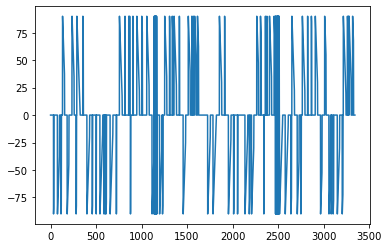

In [162]:
plt.plot(navigator.angles)
plt.show()

In [14]:
from fastai.vision.all import *
from fastai import *
import datetime;
from fastai.vision.widgets import *
import torch 
from math import pi

In [15]:
path = Path('/raid/Images/reg_data')

num_img = !ls -l '/raid/Images/reg_data' | wc -l

int(num_img[0])

34701

In [5]:
get_image_files(path)

(#34700) [Path('/raid/Images/reg_data/27471_0.png'),Path('/raid/Images/reg_data/30558_0.png'),Path('/raid/Images/reg_data/14710_0.png'),Path('/raid/Images/reg_data/15993_72.5.png'),Path('/raid/Images/reg_data/08476_0.png'),Path('/raid/Images/reg_data/25415_50.0.png'),Path('/raid/Images/reg_data/27031_-40.0.png'),Path('/raid/Images/reg_data/00967_0.png'),Path('/raid/Images/reg_data/04664_0.png'),Path('/raid/Images/reg_data/21538_0.png')...]

In [51]:
r_path = Path('/raid/Images/test/right')
l_path = Path('/raid/Images/test/left')

In [6]:
torch.cuda.current_device()

0

In [7]:
torch.cuda.set_device(1)

In [8]:
torch.cuda.current_device()

1

In [25]:
sample_lab = "/raid/Images/test/left/00627_-12.4564.png"
deg = float(sample_lab.split('_')[1][:-4])
round(deg, 4)

-12.4564

In [23]:
img_files = get_image_files(path)

In [24]:
im = PILImage.create(img_files[0])
im.shape

(240, 320)

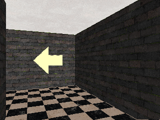

In [25]:
im.to_thumb(160)

In [16]:
def get_deg(f):
    sample_lab = f.name
    deg = float(sample_lab.split('_')[1][:-4])
    return tensor(deg).unsqueeze(0)

In [17]:
db_r = DataBlock(
    blocks=(ImageBlock, RegressionBlock()),
    get_items=get_image_files,
    get_y=get_deg,
    splitter=RandomSplitter(valid_pct=0.2, seed=47),
)

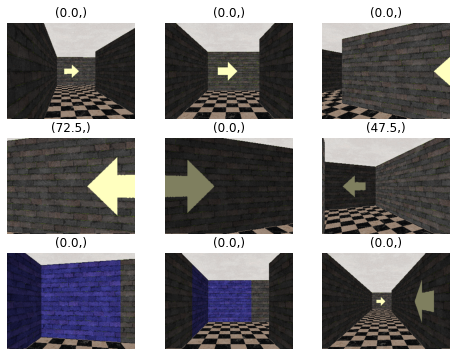

In [18]:
dls_r = db_r.dataloaders(path)
dls_r.show_batch(max_n=9, figsize=(8,6))

In [80]:
xb,yb = dls_r.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1]))

In [60]:
xb[0,0]

TensorImage([[0.8392, 0.8510, 0.8392,  ..., 0.2157, 0.1961, 0.2392],
        [0.8353, 0.8196, 0.8314,  ..., 0.2275, 0.2118, 0.2118],
        [0.8314, 0.8275, 0.8471,  ..., 0.1451, 0.1804, 0.2078],
        ...,
        [0.6078, 0.6078, 0.6196,  ..., 0.3608, 0.2745, 0.2824],
        [0.6078, 0.6078, 0.6078,  ..., 0.2627, 0.3294, 0.3608],
        [0.6078, 0.6196, 0.6275,  ..., 0.0471, 0.1412, 0.0745]],
       device='cuda:1')

In [27]:
learn = cnn_learner(
    dls_r,
    resnet18,
    y_range=(-90, 90),
    metrics=[mse], # , within_45_deg, within_30_deg, within_15_deg
)
learn.fine_tune(
    3,
    cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor="valid_loss", patience=10)],
)

epoch,train_loss,valid_loss,mse,time
0,1163.155151,764.465515,764.465515,00:42


Better model found at epoch 0 with valid_loss value: 764.4655151367188.


epoch,train_loss,valid_loss,mse,time
0,634.162292,623.923157,623.923157,00:54
1,562.769958,545.157349,545.157349,00:53
2,435.720245,516.614563,516.614563,00:53


Better model found at epoch 0 with valid_loss value: 623.9231567382812.
Better model found at epoch 1 with valid_loss value: 545.1573486328125.
Better model found at epoch 2 with valid_loss value: 516.6145629882812.


In [28]:
learn.export('/home/CAMPUS/eoca2018/raycasting-simulation/Models/regression_model02.pkl')

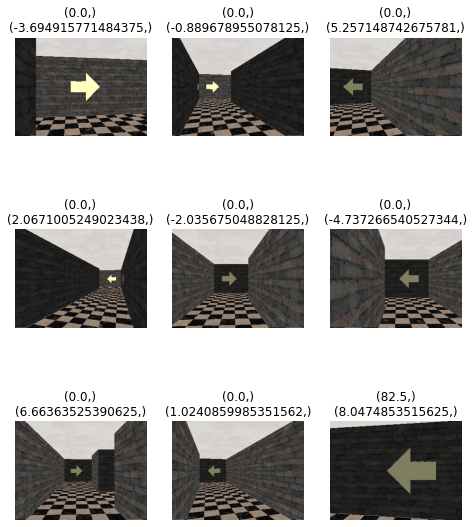

In [29]:
learn.show_results(ds_idx=1, nrows=3, figsize=(8,10))

In [110]:
learn.predict(get_image_files(path)[0])

((17.04332733154297), tensor([17.0433]), tensor([17.0433]))

In [34]:
get_image_files(path)[0]

Path('/raid/Images/test/right/00079_35.0436.png')

# Try Predicting with the Regression Model

In [40]:
import matplotlib.pyplot as plt
import sys
sys.path.append("../PycastWorld")
sys.path.append("../Gym")
from gym_pycastworld.PycastWorldEnv import PycastWorldEnv
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

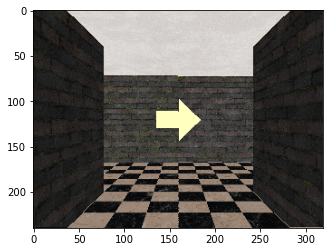

In [63]:
steps_per_episode = 1000

env = PycastWorldEnv("../Mazes/maze01.txt", 320, 240)

path = Path('/home/CAMPUS/eoca2018/raycasting-simulation/Models/regression_model02.pkl')
# Run some number of trials all starting from the
# initial location. We might eventually randomize
# the maze and the starting location.

# Grab the initial observation (not used here)
observation = env.reset()
frames = [observation.copy()]
model_inf = load_learner(path)
prev_pred = 0

plt.imshow(observation)

In [64]:
print("Predicting...")
for t in range(steps_per_episode):    
    pred_angle, _, _ =  model_inf.predict(observation)
    pred_angle = math.ceil(pred_angle[0])
    print(pred_angle)
    num_movements = abs(int(pred_angle / 20))
    
    if num_movements == 0:
        action_index = 1
        observation, reward, done, info = env.step(action_index)
        frames.append(observation.copy())
        prev_pred = pred_angle
        continue
    
    if (prev_pred > 0 and pred_angle < 0) or (prev_pred < 0 and pred_angle > 0):
        print("left-right mixup")
        action_index = 1
        observation, reward, done, info = env.step(action_index)
        frames.append(observation.copy())
        prev_pred = pred_angle
        continue
        
    # check if we have to move opposite
#     if abs(prev_pred) > abs(pred_angle) + 5:
#         print("preventing overturn")
#         action_index = 1
#         observation, reward, done, info = env.step(action_index)
#         frames.append(observation.copy())
#         continue
             
    action_index = 1
    if pred_angle > 0 and num_movements > 0:
        for i in range(num_movements):
            action_index = 0 # turn left
            observation, reward, done, info = env.step(action_index)
            frames.append(observation.copy())
    elif pred_angle < 0 and num_movements > 0:
        for i in range(num_movements):
            action_index = 2 # turn right
            observation, reward, done, info = env.step(action_index)
            frames.append(observation.copy())
#     else:
#         action_index = 1
#         observation, reward, done, info = env.step(action_index)
#         frames.append(observation.copy())

    prev_pred = pred_angle
    # Check if we reached the end goal
    if done:
        print(f"  Found goal in {t+1} steps")
        break

print(f"  Ended at position {env.world.x()}, {env.world.y()}")
env.close();

Predicting...


-4


1


0


3


3


-1


0


1


1


1


0


0


2


3


3


0


3


2


1


1


3


3


4


1


3


10


-5


-17


-13


-19


-8


-3


-56


-51


-56


-60


-61


-68


-58


-59


-55


-46


-33


-36


-34


-27


-25


-25


-28


-17


-27


-21


-8


-8


2


0


-4


-9


5


-3


-1


-1


3


8


4


0


-2


0


1


3


3


1


3


3


11


9


6


7


2


4


15


2


4


2


-12


-11


-1


-1


3


-2


-2


-6


0


0


-5


-3


1


2


-3


-2


-7


-15


-2


-7


-42


-41


-19


-6


1


-1


4


3


0


0


-1


1


-5


1


0


-7


-2


0


-5


-20


-27


-13


-4


-17


-20


15


10


-2


0


-8


-4


2


6


-5


-1


10


4


4


2


3


2


0


1


0


3


4


3


2


4


3


3


4


5


4


6


2


5


6


5


7


9


4


5


-2


19


-69
left-right mixup


-86


-80


-69


-65


-69


-59


-46


-37


-28


-16


-11


-11


-12


-8


-3


-3


-10


-5


-7


-3


-5


-10


-7


-3


-1


-2


0


-6


-4


-3


-7


-6


-8


-6


-4


-5


-3


3


-10


40
left-right mixup


74


53


54


53


49


34


34


34


19


24


22


25


12


3


8


0


0


4


1


0


7


-1


1


2


0


1


0


0


1


3


1


7


13


7


16


7


9


-1


3


41


42


67


72


0


5


4


-3


3


-3


-3


-5


-5


2


-1


0


2


2


-3


2


0


-1


-1


9


2


-4


3


-1


1


3


1


-4


-2


4


2


8


6


7


3


4


4


6


7


8


-5


-5


7


1


2


3


0


5


-1


3


-1


1


5


3


6


1


0


3


6


2


2


-4


4


4


7


3


3


4


4


9


15


11


18


29


11


9


15


12


12


15


4


18


88


86


82


64


58


55


44


46


34


24


19


12


6


6


9


3


3


0


1


1


1


3


8


8


6


3


8


3


6


9


13


15


17


18


23


25


22


20


9


14


14


18


10


7


1


0


15


-12


-80


-70


-78


-66


-59


-55


-54


-47


-34


-36


-37


-31


-32


-26


-12


-18


-23


-12


-11


-9


-20


-9


-11


-6


-7


-2


0


0


-1


1


-2


-3


-6


-1


-2


-1


-2


3


-1


-6


-7


0


6


19


-26
left-right mixup


-87


-87


-81


-78


-74


-68


-56


-52


-55


-28


-17


-20


-1


-13


-6


-6


-6


-10


-12


-20


-14


-32


-25


-23


-11


-9


-15


-10


-8


-9


-21


-15


-21


-6


-9


-7


-10


-5


-15


-12


-5


-13


-34


-28


-18


-16


-6


-32


-13


-11


-3


-7


-11


-2


-2


-5


-7


3


-1


-3


-1


-1


-4


1


2


-3


2


1


2


7


4


0


-1


1


0


-6


-1


0


0


-2


-7


0


-10


-17


-6


-11


2


-1


-24


-4


-86


-84


-71


-67


-63


-58


-46


-38


-38


-32


-20


-16


-21


-17


-10


-10


-2


-3


-1


-3


-1


-2


0


0


-2


-2


-1


-3


-9


-3


-2


-2


0


-5


-3


3


-6


2


-4


-2


0


-11


0


-3


-3


54
left-right mixup


75


71


73


61


47


41


29


28


31


16


7


-4


-7


-6


-11


0


-5


2


5


1


-2


2


1


4


4


6


4


7


1


0


-1


-5


1


-1


2


7


10


58


75


48


32


23


28


7


-5


5


2


7


2


-3


-3


-1


-2


-1


1


0


2


0


3


3


1


1


0


0


0


1


-1


0


5


5


-1


0


0


0


-21


3


-1


13


10


7


13


11


25


12


-16


34
left-right mixup


89


88


84


71


57


52


48


36


35


35


29


23


35


20


5


8


4


5


1


0


1


1


1


1


-5


6


7


1


-3


0


1


-2


4


-3


-1


5


5


2


4


8


3


7


0


-7


-10


-2


69
left-right mixup


68


19


1


-9


-10


-3


-8


-4


-2


-1


-3


-1


-1


-3


0


0


0


1


1


0


1


3


1


0


0


0


1


1


1


2


4


2


11


9


10


9


8


3


9


22


25


26


24


29


25


20


26


14


-31
left-right mixup


-81


-85


-84


-82


-74


-67


-62


-53


-44


-29


-26


-16


-18


-7


-13


-14


-9


-18


-28


-29


-22


-15


-27


-15


-17


-17


-13


-16


-21


-12


-23


-17


-11


-4


-17


-15


-11


-3


-12


-10


-19


-23


-36


-29


-35


-22


-12


-6


-2


-7


10


-1


-6


-3


-1


-7


-3


-3


-2


-7


-6


-1


-2


-2


2


-5


-14


-3


1


-3


17


1


-4


-9


-1


-2


-6


-2


1


-7


-1


-1


-6


-1


0


-1


-6


0


-2


-5


13


1


-3


-8


0


-3


-7


1


2


-4


-2


2


-4


0


3


-1


-2


0


1


2


19


4


-3


2


1


2


-1


4


3


3


2


4


-1


1


5


-1


-1


1


4


28


-1


8


4


-3


-2


1


-1


-3


3


6


-1


-3


0


-3


-1


5


0


-1


0


-2


-3


5


1


-4


-2


0


-1


-2


4


6


0


-2


0


-1


0


3


1


0


-1


-1


1


5


0


-3


-1


-2


-2


-3


1


3


1


-1


-2


-1


0


0


1


1


0


-1


-2


2


5


6


5


2


6


9


29
  Found goal in 945 steps
  Ended at position 18.492342933564025, 19.284565048480793


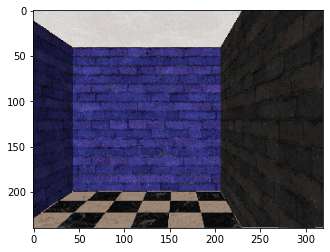

In [65]:
fig, ax = plt.subplots()
ln = plt.imshow(frames[0])
def init():
    ln.set_data(frames[0])
    return [ln]

def update(frame):
#     print(frame)
    ln.set_array(frame)
    return [ln] 

ani = FuncAnimation(fig, update, frames, init_func=init, interval=60)
# plt.show()
# ani.save("prediction_" + str(datetime.datetime.now()) + ".mp4")
smaller_frames = frames[::3] 
ani = FuncAnimation(fig, update, smaller_frames, init_func=init, interval=60)
HTML(ani.to_html5_video())